In [1]:
#| code-fold: true
#| code-summary: "Packages and plotting settings"
#| output: false

%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from copy import deepcopy
from matplotlib.colors import Normalize
import matplotlib
from matplotlib.ticker import ScalarFormatter
import seaborn 
seaborn.set_context('talk')
# seaborn.set_context('poster')
# import scienceplots
# plt.style.use(['science','ieee'])
# plt.style.use(['science','~/.config/matplotlib/stylelib/ingo.mpl'])
# plt.style.use('~/.config/matplotlib/stylelib/ingo.mplstyle')
# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })

# cm = plt.get_cmap('tab20')
# cm = plt.get_cmap('Dark2')
# for color in plt.cycler("color", cm.colors):
    # print(matplotlib.colors.to_hex(color['color']))

main_dir = os.getenv("SMS")
from code_11_ijshs import *

#### Fully resolved (OpenFOAM) simulation

In [2]:
experiments = {}
# path_to_openfoam = 'outputs/nozzle_openfoam_jonas/VTK'
path_to_openfoam = 'outputs/openfoam_nozzle_2d'

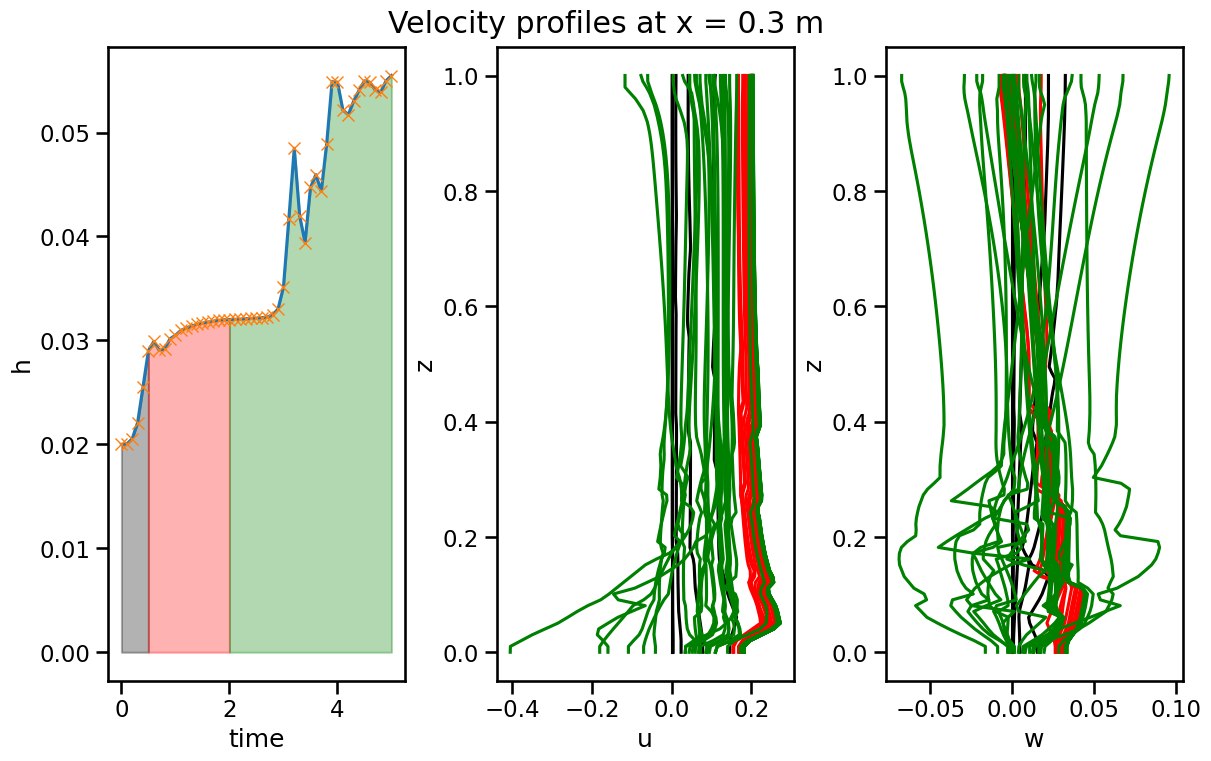

In [3]:
#| code-fold: true
#| code-summary: "Flow conditions at the beginning of the flow"
#| output: false

directory = os.path.join(main_dir, path_to_openfoam)
pos, h, u, w, iteration = extract_1d_data(directory, pos=[0.3, 0, 0], stride=10)

fig, ax = plt.subplots(1, 3, constrained_layout=True, figsize=(12,7.5))
fig.suptitle(f'Velocity profiles at x = {0.3} m')
ax[0].set_xlabel('time')
ax[0].set_ylabel('h')
ax[1].set_xlabel('u')
ax[1].set_ylabel('z')
ax[2].set_xlabel('w')
ax[2].set_ylabel('z')

z = np.linspace(0, 1, 100)
dt = 0.01
time = dt * iteration

regions = [0,5,20,1000]
ax[0].plot(time, h)
ax[0].plot(time, h, 'x')
ax[0].fill_between(time[regions[0]:regions[1]+1], h[regions[0]:regions[1]+1], color='k', alpha=0.3)
ax[0].fill_between(time[regions[1]:regions[2]+1], h[regions[1]:regions[2]+1], color='r', alpha=0.3)
ax[0].fill_between(time[regions[2]:regions[3]+1], h[regions[2]:regions[3]+1], color='g', alpha=0.3)
for i in range(u.shape[0]):
    if i >= regions[0] and i < regions[1]:
        ax[1].plot(u[i], z, 'k')
        ax[2].plot(w[i], z, 'k')
    elif i >= regions[1] and i < regions[2]:
        ax[1].plot(u[i], z, 'r')
        ax[2].plot(w[i], z, 'r')
    elif i >= regions[2] and i <= regions[3]:
        ax[1].plot(u[i], z, 'g')
        ax[2].plot(w[i], z, 'g')

experiments["0.3"] = {"pos": pos.copy(), "h": h.copy(), "u":u.copy(), "w": w.copy(), "timeline":time}
fig.savefig('images/VP03.png')

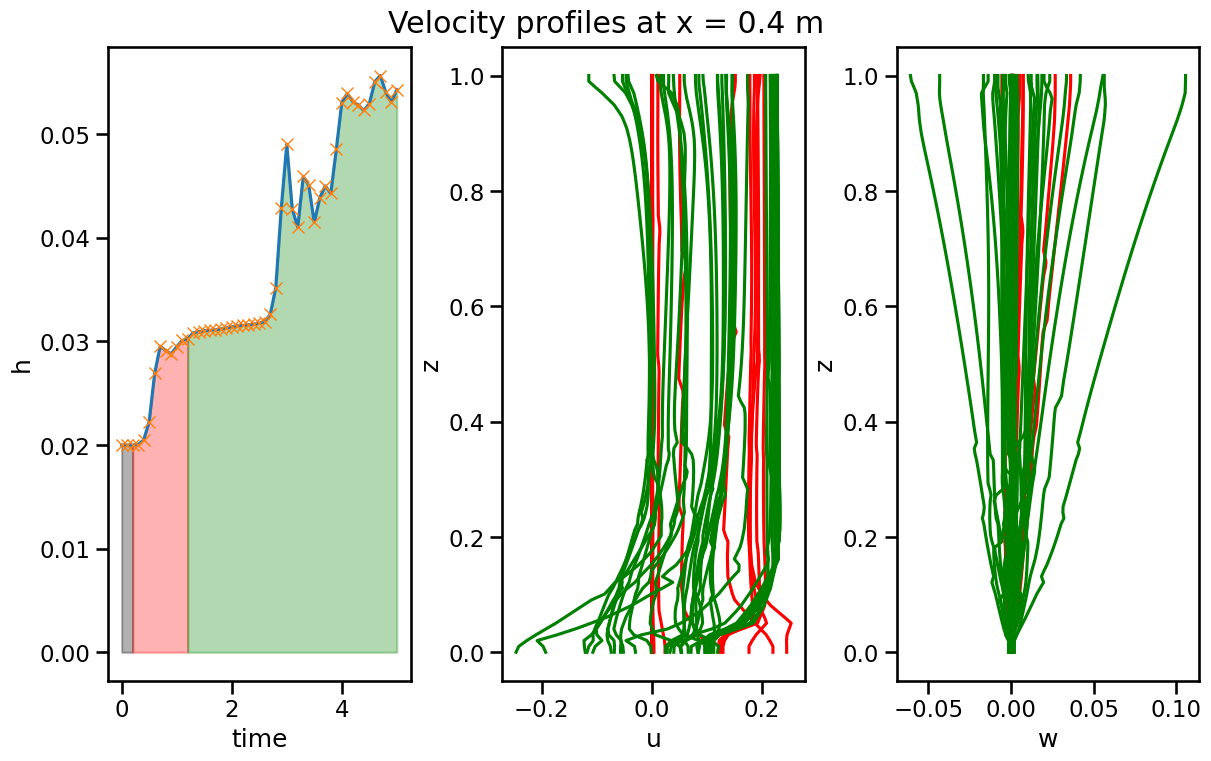

In [4]:
#| code-fold: true
#| code-summary: "Flow conditions at the beginning of the flow"
#| output: false

directory = os.path.join(main_dir, path_to_openfoam)
pos, h, u, w, iteration = extract_1d_data(directory, pos=[0.4, 0, 0], stride=10)

fig, ax = plt.subplots(1, 3, constrained_layout=True, figsize=(12,7.5))
fig.suptitle(f'Velocity profiles at x = {0.4} m')
ax[0].set_xlabel('time')
ax[0].set_ylabel('h')
ax[1].set_xlabel('u')
ax[1].set_ylabel('z')
ax[2].set_xlabel('w')
ax[2].set_ylabel('z')

z = np.linspace(0, 1, 100)
dt = 0.01
time = dt * iteration

regions = [0, 2, 12, 1000]
ax[0].plot(time, h)
ax[0].plot(time, h, 'x')
ax[0].fill_between(time[regions[0]:regions[1]+1], h[regions[0]:regions[1]+1], color='k', alpha=0.3)
ax[0].fill_between(time[regions[1]:regions[2]+1], h[regions[1]:regions[2]+1], color='r', alpha=0.3)
ax[0].fill_between(time[regions[2]:regions[3]+1], h[regions[2]:regions[3]+1], color='g', alpha=0.3)
for i in range(u.shape[0]):
    if i >= regions[0] and i < regions[1]:
        ax[1].plot(u[i], z, 'k')
        ax[2].plot(w[i], z, 'k')
    elif i >= regions[1] and i < regions[2]:
        ax[1].plot(u[i], z, 'r')
        ax[2].plot(w[i], z, 'r')
    elif i >= regions[2] and i <= regions[3]:
        ax[1].plot(u[i], z, 'g')
        ax[2].plot(w[i], z, 'g')
experiments["0.4"] = {"pos": pos.copy(), "h": h.copy(), "u":u.copy(), "w": w.copy(), "timeline":time}
fig.savefig('images/VP04.png')

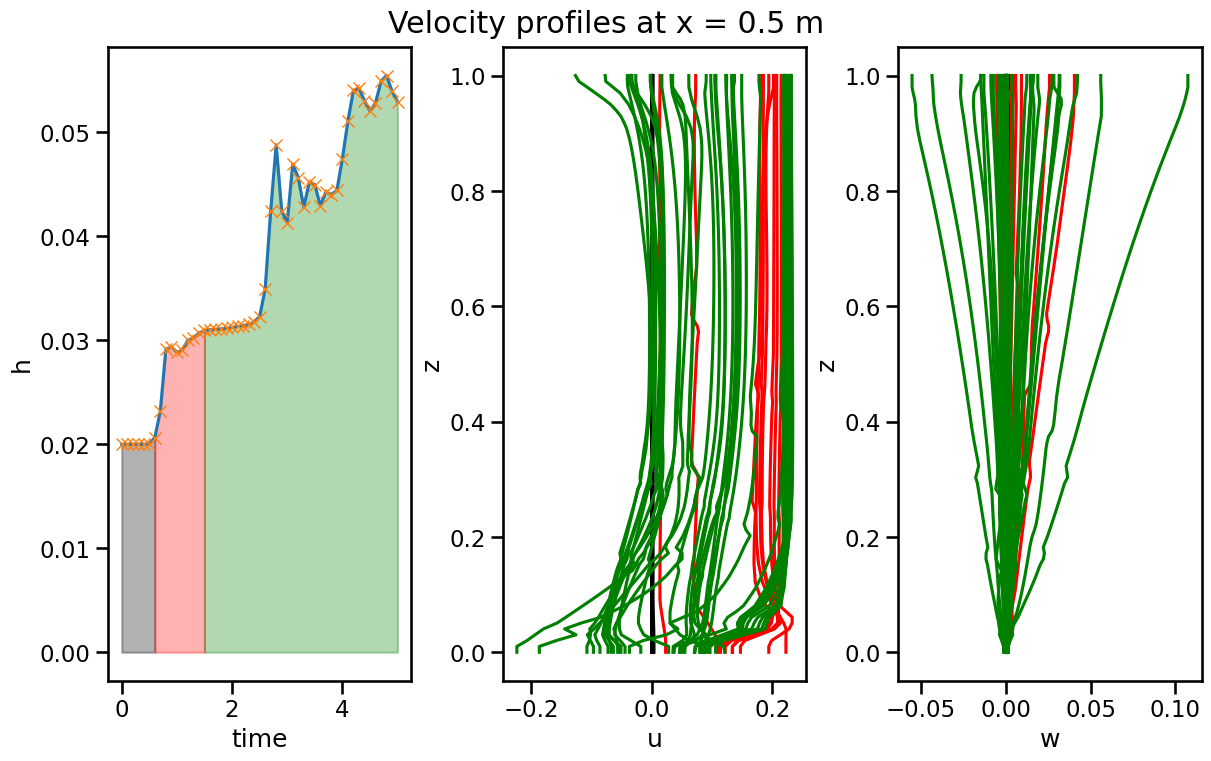

In [5]:
#| code-fold: true
#| code-summary: "Flow conditions at the beginning of the flow"
#| output: false

directory = os.path.join(main_dir, path_to_openfoam)
pos, h, u, w, iteration = extract_1d_data(directory, pos=[0.5, 0, 0], stride=10)

fig, ax = plt.subplots(1, 3, constrained_layout=True, figsize=(12,7.5))
fig.suptitle(f'Velocity profiles at x = {0.5} m')
ax[0].set_xlabel('time')
ax[0].set_ylabel('h')
ax[1].set_xlabel('u')
ax[1].set_ylabel('z')
ax[2].set_xlabel('w')
ax[2].set_ylabel('z')

z = np.linspace(0, 1, 100)
dt = 0.01
time = dt * iteration

regions = [0, 6, 15, 1000]
ax[0].plot(time, h)
ax[0].plot(time, h, 'x')
ax[0].fill_between(time[regions[0]:regions[1]+1], h[regions[0]:regions[1]+1], color='k', alpha=0.3)
ax[0].fill_between(time[regions[1]:regions[2]+1], h[regions[1]:regions[2]+1], color='r', alpha=0.3)
ax[0].fill_between(time[regions[2]:regions[3]+1], h[regions[2]:regions[3]+1], color='g', alpha=0.3)
for i in range(u.shape[0]):
    if i >= regions[0] and i < regions[1]:
        ax[1].plot(u[i], z, 'k')
        ax[2].plot(w[i], z, 'k')
    elif i >= regions[1] and i < regions[2]:
        ax[1].plot(u[i], z, 'r')
        ax[2].plot(w[i], z, 'r')
    elif i >= regions[2] and i <= regions[3]:
        ax[1].plot(u[i], z, 'g')
        ax[2].plot(w[i], z, 'g')
experiments["0.5"] = {"pos": pos.copy(), "h": h.copy(), "u":u.copy(), "w": w.copy(), "timeline":time}
fig.savefig('images/VP05.png')

In [ ]:
from library.model.model import *
level = 8
basis_analytical =Legendre_shifted(order=level+1)
basis_readable = [basis_analytical.get(k) for k in range(level+1)]
basis = [basis_analytical.get_lambda(k) for k in range(level+1)]
print(basis_readable)

u_test = u[-1]
moments = project_to_smm(u_test, z, basis=basis)
print(f'Moments: {moments}')
reconstructions = []
for k in range(level+1):
    reconst = moments[0] * basis[0](z)
    for i in range(1,k+1):
        reconst += moments[i] * basis[i](z)
    reconstructions.append(reconst)

errors = []
rel_errors = []
error_0 = np.trapz((u_test - reconstructions[0])**2, z)
for k in range(level+1):
    error = np.trapz((u_test - reconstructions[k])**2, z)
    errors.append(error)
    rel_errors.append(error_0/error)


fig, ax = plt.subplots()
plt.plot(u_test, z, '*', label='openfoam')
# for k in range(level+1):
#     ax.plot(reconstructions[k], z, label=f'level {k}')

for k in [0, 1, 2, 4, 6, 8]:
    ax.plot(reconstructions[k], z, label=f'level {k}')

plt.title('Velocity projection at 3d/2d interface')
plt.legend()

print(f'errors: {errors}')
print(f'relative errors: {rel_errors}')
fig.savefig('images/ProjectionInflow.png')

[1, 1 - 2*x, 3*(2*x - 1)**2/2 - 1/2, 3*x - 5*(2*x - 1)**3/2 - 3/2, 35*(2*x - 1)**4/8 - 15*(2*x - 1)**2/4 + 3/8, -15*x/4 - 63*(2*x - 1)**5/8 + 35*(2*x - 1)**3/4 + 15/8, 231*(2*x - 1)**6/16 - 315*(2*x - 1)**4/16 + 105*(2*x - 1)**2/16 - 5/16, 35*x/8 - 429*(2*x - 1)**7/16 + 693*(2*x - 1)**5/16 - 315*(2*x - 1)**3/16 - 35/16, 6435*(2*x - 1)**8/128 - 3003*(2*x - 1)**6/32 + 3465*(2*x - 1)**4/64 - 315*(2*x - 1)**2/32 + 35/128]


NameError: name 'u' is not defined

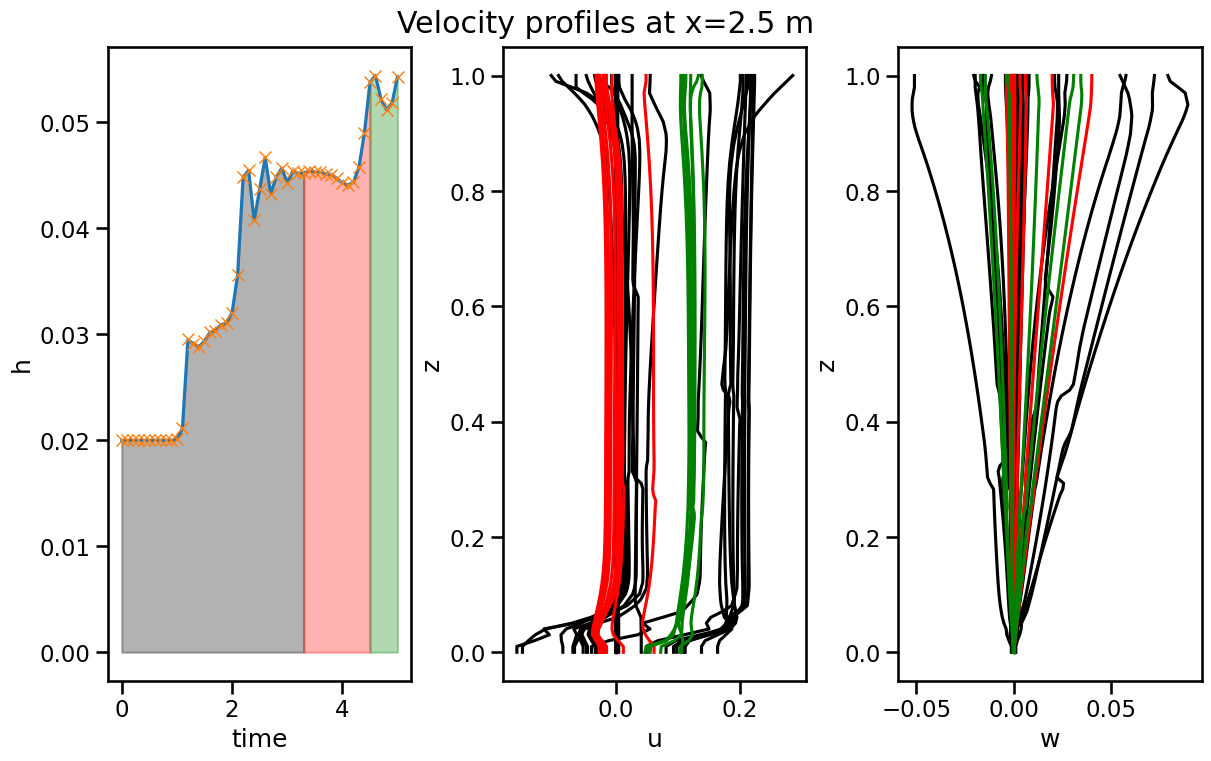

In [ ]:
#| code-fold: true
#| code-summary: "Flow conditons at the end of the channel"
#| output: true

directory = os.path.join(main_dir, path_to_openfoam)
pos, h, u, w, iteration = extract_1d_data(directory, pos=[0.75, 0, 0.5], stride=10)

fig, ax = plt.subplots(1, 3, constrained_layout=True, figsize=(12,7.5))
fig.suptitle(f'Velocity profiles at x={2.5} m')
ax[0].set_xlabel('time')
ax[0].set_ylabel('h')
ax[1].set_xlabel('u')
ax[1].set_ylabel('z')
ax[2].set_xlabel('w')
ax[2].set_ylabel('z')

z = np.linspace(0, 1, 100)
dt = 0.01
time = dt * iteration

regions = [0, 33, 45, 1000]
ax[0].plot(time, h)
ax[0].plot(time, h, 'x')
ax[0].fill_between(time[regions[0]:regions[1]+1], h[regions[0]:regions[1]+1], color='k', alpha=0.3)
ax[0].fill_between(time[regions[1]:regions[2]+1], h[regions[1]:regions[2]+1], color='r', alpha=0.3)
ax[0].fill_between(time[regions[2]:regions[3]+1], h[regions[2]:regions[3]+1], color='g', alpha=0.3)
for i in range(u.shape[0]):
    if i >= regions[0] and i < regions[1]:
        ax[1].plot(u[i], z, 'k')
        ax[2].plot(w[i], z, 'k')
    elif i >= regions[1] and i < regions[2]:
        ax[1].plot(u[i], z, 'r')
        ax[2].plot(w[i], z, 'r')
    elif i >= regions[2] and i <= regions[3]:
        ax[1].plot(u[i], z, 'g')
        ax[2].plot(w[i], z, 'g')
experiments["2.5"] = {"pos": pos.copy(), "h": h.copy(), "u":u.copy(), "w": w.copy(), "timeline":time}
fig.savefig('images/VP075.png')

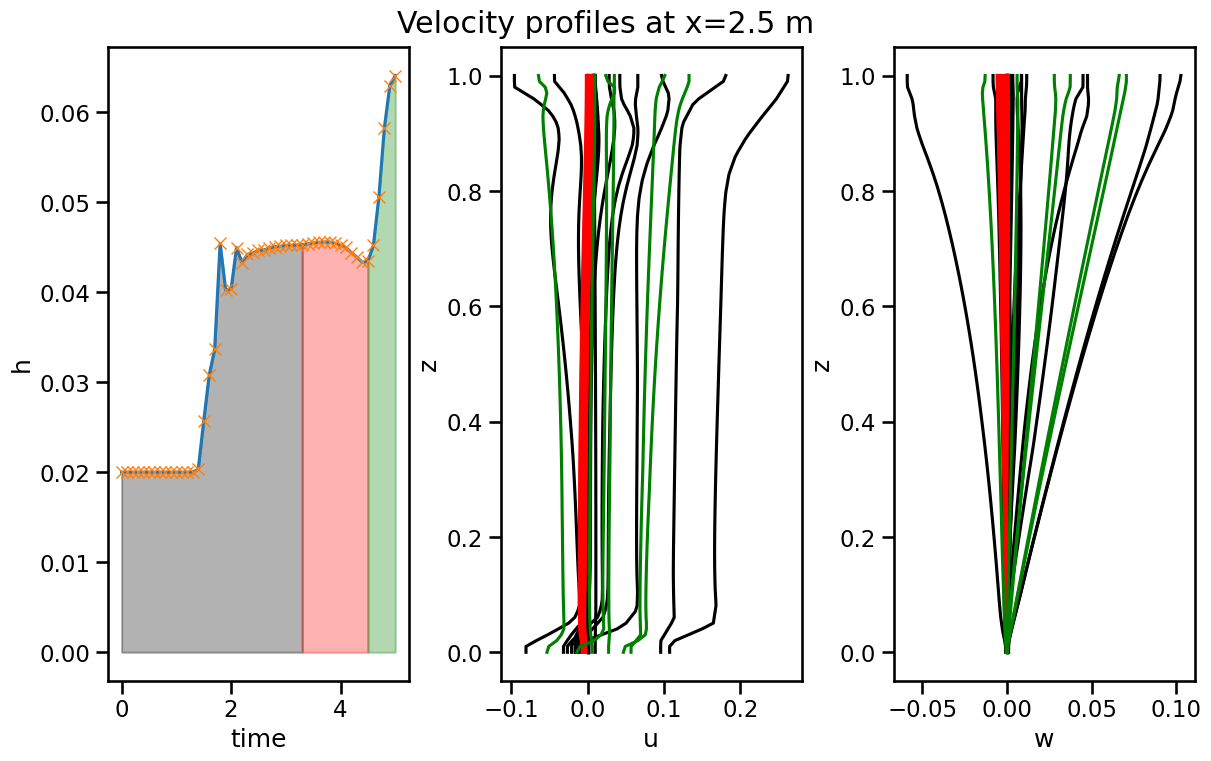

In [ ]:
#| code-fold: true
#| code-summary: "Flow conditons at the end of the channel"
#| output: true

directory = os.path.join(main_dir, path_to_openfoam)
pos, h, u, w, iteration = extract_1d_data(directory, pos=[0.95, 0, 0.5], stride=10)

fig, ax = plt.subplots(1, 3, constrained_layout=True, figsize=(12,7.5))
fig.suptitle(f'Velocity profiles at x={2.5} m')
ax[0].set_xlabel('time')
ax[0].set_ylabel('h')
ax[1].set_xlabel('u')
ax[1].set_ylabel('z')
ax[2].set_xlabel('w')
ax[2].set_ylabel('z')

z = np.linspace(0, 1, 100)
dt = 0.01
time = dt * iteration

regions = [0, 33, 45, 1000]
ax[0].plot(time, h)
ax[0].plot(time, h, 'x')
ax[0].fill_between(time[regions[0]:regions[1]+1], h[regions[0]:regions[1]+1], color='k', alpha=0.3)
ax[0].fill_between(time[regions[1]:regions[2]+1], h[regions[1]:regions[2]+1], color='r', alpha=0.3)
ax[0].fill_between(time[regions[2]:regions[3]+1], h[regions[2]:regions[3]+1], color='g', alpha=0.3)
for i in range(u.shape[0]):
    if i >= regions[0] and i < regions[1]:
        ax[1].plot(u[i], z, 'k')
        ax[2].plot(w[i], z, 'k')
    elif i >= regions[1] and i < regions[2]:
        ax[1].plot(u[i], z, 'r')
        ax[2].plot(w[i], z, 'r')
    elif i >= regions[2] and i <= regions[3]:
        ax[1].plot(u[i], z, 'g')
        ax[2].plot(w[i], z, 'g')
experiments["2.5"] = {"pos": pos.copy(), "h": h.copy(), "u":u.copy(), "w": w.copy(), "timeline":time}
fig.savefig('images/VP25.png')

#### Depth-averaged (Shallow Moment) simulation

In [ ]:
#| code-fold: true
#| code-summary: "Imports"

import numpy as np
import pytest
from types import SimpleNamespace

from library.model.model import *
from library.pysolver.solver import *
import library.model.initial_conditions as IC
import library.model.boundary_conditions as BC
from library.pysolver.ode import RK1
import library.misc.io as io
from library.pysolver.reconstruction import GradientMesh
import library.mesh.mesh as petscMesh
import library.postprocessing.postprocessing as postprocessing
import argparse


In [ ]:
#| code-fold: true
#| code-summary: "Mesh"
#| output: false
mesh = petscMesh.Mesh.create_1d((0.5, 1.0), 100)


In [ ]:
dx = mesh.cell_centers[0,1] - mesh.cell_centers[0,0]

In [ ]:
h_inflow ,moments_inflow, moments_w_inflow, timeline_inflow, u_inflow, w_inflow = project_openfoam_to_smm(directory, pos=[0.5, 0, 0], stride=1, output_uw=True, level=10)

inflow moments: [ 5.98923421e-03 -2.06282906e-04 -1.60301209e-04 -2.05684710e-04
 -3.42811643e-04 -4.88803312e-04 -5.00530538e-04 -4.12955896e-04
 -2.79050717e-04 -1.62109469e-04 -2.44263467e-05]
errors: [0.00011626358766796271, 0.00010060747877389817, 9.493864505230903e-05, 8.822655481362929e-05, 7.36631501914873e-05, 4.951530390107816e-05, 2.8224448273831344e-05, 1.6038223815143998e-05, 1.1319783805686018e-05]
relative errors: [1.0, 1.15561575625257, 1.2246181478986151, 1.3177845141245643, 1.5783140873793151, 2.348033405999779, 4.11925103158732, 7.249156079127759, 10.270831109827608]


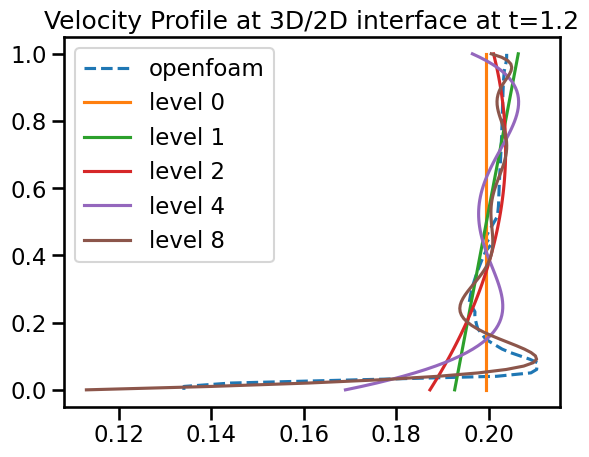

In [ ]:
from library.model.model import *

# h_inflow ,moments_inflow, moments_w_inflow, timeline_inflow, u_inflow, w_inflow = project_openfoam_to_smm(directory, pos=[0.5, 0, 0], stride=60, output_uw=True)
level = 8
basis_analytical =Legendre_shifted(order=level+1)
basis_readable = [basis_analytical.get(k) for k in range(level+1)]
basis = [basis_analytical.get_lambda(k) for k in range(level+1)]

i_time = 120
moments = moments_inflow[i_time]
print(f'inflow moments: {moments * h_inflow[i_time]}')

reconstructions = []
for k in range(level+1):
    reconst = moments[0] * basis[0](z)
    for i in range(1,k+1):
        reconst += moments[i] * basis[i](z)
    reconstructions.append(reconst)

errors = []
rel_errors = []
error_0 = np.trapz((u_inflow[i_time] - reconstructions[0])**2, z)
for k in range(level+1):
    error = np.trapz((u_inflow[i_time] - reconstructions[k])**2, z)
    errors.append(error)
    rel_errors.append(error_0/error)


fig, ax = plt.subplots()
plt.plot(u_inflow[i_time], z, '--', label='openfoam')
# for k in range(level+1):
#     ax.plot(reconstructions[k], z, label=f'level {k}')

for k in [0, 1, 2, 4, 8]:
    ax.plot(reconstructions[k], z, label=f'level {k}')

plt.legend()

print(f'errors: {errors}')
print(f'relative errors: {rel_errors}')
plt.title(f"Velocity Profile at 3D/2D interface at t={60 * 2 * dt}")
fig.savefig("images/VP_inflow2.png")

In [ ]:
#| code-summary: "Model"
#| code-fold: true
level = 0
offset = level+1

data_dict = {}
data_dict[0] = h_inflow 
for i in range(level+1):
    data_dict[1+i] = h_inflow * moments_inflow[:, i]
# data_dict[1] = h_inflow * np.sqrt((moments_inflow[:, 0]**2 + moments_w_inflow[:, 0]**2))
# data_dict[2] = h_inflow * moments_inflow[:, 1]
# for i in range(2, level+1):
#     data_dict[i] = np.zeros_like(h_inflow)

bcs = BC.BoundaryConditions(
    [
        BC.FromData(physical_tag='left', prescribe_fields=data_dict, timeline=timeline_inflow),
        BC.Wall(physical_tag="right", momentum_field_indices=[[i+1] for i in range(level+1)], wall_slip=0.),
    ]
)



ic = IC.Constant(
    constants=lambda n_fields: np.array(
        [0.02, 0.0] + [0.0 for i in range(n_fields - 2)]
    )
)

# def custom_ic(x):
#     Q = np.zeros(3+2*level, dtype=float)
#     Q[0] = 2*np.ones_like(x[0])
#     Q[1] = x[0]
#     Q[2] = x[1]
#     Q[3] = x[0]**2 
#     Q[4] = x[1]**2 
#     return Q

# ic = IC.UserFunction(custom_ic)


settings = Settings(
    name="ShallowMoments",
    parameters={"g": 9.81, "C": 10.0, "nu": 1.034*10**(-6), "rho": 1, "lamda": 3, "beta": 0.0100},
    reconstruction=recon.constant,
    num_flux=flux.LLF(),
    nc_flux=nonconservative_flux.segmentpath(1),
    compute_dt=timestepping.adaptive(CFL=.9),
    time_end=5.,
    output_snapshots=100,
    output_clean_dir=True,
    output_dir="outputs/output_ijshs",
)


# model = ShallowMoments(
#     dimension=1,
#     fields=2 + level,
#     aux_fields=0,
#     parameters=settings.parameters,
#     boundary_conditions=bcs,
#     initial_conditions=ic,
#     # settings={"friction": []},
#     # settings={"friction": ["newtonian"]},
#     # settings={"friction": ["chezy"]},
#     # settings={"friction": ["shear"]},
#     # settings={"friction": ["shear_crazy"]},
#     # settings={"friction": ["shear", "newtonian"]},
#     settings={"friction": ["chezy", "newtonian"]},
#     # settings={"friction": ["chezy"]},
#     basis=Basis(basis=Legendre_shifted(order=level)),
# )




In [ ]:
#| code-fold: true
#| code-summary: "Simulation"
#| output: false
jax_fvm_unsteady_semidiscrete(
    mesh, model, settings, ode_solver_flux=RK1, ode_solver_source=RK1
)
# try:
#     jax_fvm_unsteady_semidiscrete(
#         mesh, model, settings, ode_solver_flux=RK1, ode_solver_source=RKimplicit
#     )
# except Exception as e:
    # print(f"Error \n {e}")
# io.generate_vtk(os.path.join(settings.output_dir, f'{settings.name}.h5'))
# postprocessing.recover_3d_from_smm_as_vtk(
#     model,
#     settings.output_dir,
#     os.path.join(settings.output_dir, "mesh.hdf5"),
#     os.path.join(settings.output_dir, "fields.hdf5"),
#     Nz=10,
#     start_at_time=1.0,
# )

NameError: name 'model' is not defined

In [ ]:
io.generate_vtk(os.path.join(settings.output_dir, f'{settings.name}.h5'))

## Plots publication

In [ ]:
pos = 0.75
h_openfoam, moments_openfoam, moments_w_openfoam, timeline_openfoam, u_openfoam, w_openfoam = project_openfoam_to_smm(directory, pos=[pos, 0, 0], stride=10, output_uw = True, level=20, weights='uniform')
mom_u_openfoam = moments_openfoam[:, 0]
h_openfoam = h_openfoam

dataset = {}
Q_openfoam = np.zeros((moments_openfoam.shape[1]+1, moments_openfoam.shape[0]) )
Q_openfoam[0, :] = h_openfoam
Q_openfoam[1:1+moments_openfoam.shape[1], :] = moments_openfoam.T
# shear = shear_at_bottom_moments(Q_openfoam[1:].T)
shear = (u_openfoam[:, 3] - u_openfoam[:, 0])/(z[3]-z[0])
dataset['openfoam'] = {'Q': Q_openfoam[:, :-10], 'timeline': timeline_openfoam[:-10], 'shear': shear[:-10]}

In [ ]:
pos = 0.75
# x_smm, Q_smm, Qaux_smm, timeline_smm = io.load_timeline_of_fields_from_hdf5(os.path.join('outputs/save_ijshs', "lvl8_chezy10.h5" ))
x_smm, Q_smm, Qaux_smm, timeline_smm = io.load_timeline_of_fields_from_hdf5(os.path.join('outputs/output_ijshs', "ShallowMoments.h5" ))
Q_smm = Q_smm
Q_timeline = timeline_smm
i_pos = ((x_smm-pos)**2).argmin()

h_smm = Q_smm[:, 0, i_pos]
moments_smm = Q_smm[:, 1:, i_pos] / np.repeat(h_smm, Q_smm.shape[1]-1).reshape((h_smm.shape[0], Q_smm.shape[1]-1))
Q = np.zeros((22, Q_smm.shape[0]))
Q[0, :] = h_smm
Q[1:1+moments_smm.shape[1], :] = moments_smm.T

shear = shear_at_bottom_moments(Q[1:].T)
error = compute_error(Q[1:].T, Q_timeline, Q_openfoam[1:].T, timeline_openfoam, z)
dataset['lvl8'] = {'Q': Q[:, :-20], 'timeline': timeline_smm[:-20], 'shear': shear[:-20], 'error': error[:-20]}
print('test')

test


In [ ]:
pos = 0.75
x_smm, Q_smm, Qaux_smm, timeline_smm = io.load_timeline_of_fields_from_hdf5(os.path.join('outputs/save_ijshs', "lvl6_chezy30.h5" ))
# x_smm, Q_smm, Qaux_smm, timeline_smm = io.load_timeline_of_fields_from_hdf5(os.path.join('outputs/output_ijshs', "ShallowMoments.h5" ))
Q_smm = Q_smm
Q_timeline = timeline_smm
i_pos = ((x_smm-pos)**2).argmin()

h_smm = Q_smm[:, 0, i_pos]
moments_smm = Q_smm[:, 1:, i_pos] / np.repeat(h_smm, Q_smm.shape[1]-1).reshape((h_smm.shape[0], Q_smm.shape[1]-1))
Q = np.zeros((22, Q_smm.shape[0]))
Q[0, :] = h_smm
Q[1:1+moments_smm.shape[1], :] = moments_smm.T

# shear = shear_at_bottom_moments(moments_smm)
# error = compute_error(Q[1:].T, Q_timeline, Q_openfoam[1:].T, timeline_openfoam, z)
# error_h, error = compute_error_over_h_and_u(Q_smm, timeline_smm, Q_openfoam, timeline_openfoam, z, dx)
dataset['lvl6'] = {'Q': Q[:, :-20], 'timeline': timeline_smm[:-20], 'shear': shear[:-20], 'error': error[:-20]}


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [ ]:
x_smm, Q_smm, Qaux_smm, timeline_smm = io.load_timeline_of_fields_from_hdf5(os.path.join('outputs/save_ijshs', "lvl4_chezy10.h5" ))
Q_smm = Q_smm
Q_timeline = timeline_smm
i_pos = ((x_smm-pos)**2).argmin()

h_smm = Q_smm[:, 0, i_pos]
moments_smm = Q_smm[:, 1:, i_pos] / np.repeat(h_smm, Q_smm.shape[1]-1).reshape((h_smm.shape[0], Q_smm.shape[1]-1))
Q = np.zeros((22, Q_smm.shape[0]))
Q[0, :] = h_smm
Q[1:1+moments_smm.shape[1], :] = moments_smm.T

shear = shear_at_bottom_moments(moments_smm)
error = compute_error(Q[1:].T, Q_timeline, Q_openfoam[1:].T, timeline_openfoam, z)
dataset['lvl4'] = {'Q': Q[:, :-20], 'timeline': timeline_smm[:-20], 'shear': shear[:-20], 'error': error[:-20]}

In [ ]:
x_smm, Q_smm, Qaux_smm, timeline_smm = io.load_timeline_of_fields_from_hdf5(os.path.join('outputs/save_ijshs', "lvl2_chezy10.h5" ))
Q_smm = Q_smm
Q_timeline = timeline_smm
i_pos = ((x_smm-pos)**2).argmin()

h_smm = Q_smm[:, 0, i_pos]
moments_smm = Q_smm[:, 1:, i_pos] / np.repeat(h_smm, Q_smm.shape[1]-1).reshape((h_smm.shape[0], Q_smm.shape[1]-1))
Q = np.zeros((22, Q_smm.shape[0]))
Q[0, :] = h_smm
Q[1:1+moments_smm.shape[1], :] = moments_smm.T

shear = shear_at_bottom_moments(moments_smm)
error = compute_error(Q[1:].T, Q_timeline, Q_openfoam[1:].T, timeline_openfoam, z)
dataset['lvl2'] = {'Q': Q[:, :-20], 'timeline': timeline_smm[:-20], 'shear': shear[:-20], 'error': error[:-20]}

In [ ]:
x_smm, Q_smm, Qaux_smm, timeline_smm = io.load_timeline_of_fields_from_hdf5(os.path.join('outputs/save_ijshs', "lvl1_chezy10.h5" ))
Q_smm = Q_smm
Q_timeline = timeline_smm
i_pos = ((x_smm-pos)**2).argmin()

h_smm = Q_smm[:, 0, i_pos]
moments_smm = Q_smm[:, 1:, i_pos] / np.repeat(h_smm, Q_smm.shape[1]-1).reshape((h_smm.shape[0], Q_smm.shape[1]-1))
Q = np.zeros((22, Q_smm.shape[0]))
Q[0, :] = h_smm
Q[1:1+moments_smm.shape[1], :] = moments_smm.T

shear = shear_at_bottom_moments(moments_smm)
error = compute_error(Q[1:].T, Q_timeline, Q_openfoam[1:].T, timeline_openfoam, z)
dataset['lvl2'] = {'Q': Q[:, :-20], 'timeline': timeline_smm[:-20], 'shear': shear[:-20], 'error': error[:-20]}

In [ ]:
x_smm, Q_smm, Qaux_smm, timeline_smm = io.load_timeline_of_fields_from_hdf5(os.path.join('outputs/save_ijshs', "lvl0_chezy10.h5" ))
Q_smm = Q_smm
Q_timeline = timeline_smm
i_pos = ((x_smm-pos)**2).argmin()

h_smm = Q_smm[:, 0, i_pos]
moments_smm = Q_smm[:, 1:, i_pos] / np.repeat(h_smm, Q_smm.shape[1]-1).reshape((h_smm.shape[0], Q_smm.shape[1]-1))
Q = np.zeros((22, Q_smm.shape[0]))
Q[0, :] = h_smm
Q[1:1+moments_smm.shape[1], :] = moments_smm.T

shear = shear_at_bottom_moments(moments_smm)
error = compute_error(Q[1:].T, Q_timeline, Q_openfoam[1:].T, timeline_openfoam, z)
dataset['lvl0'] = {'Q': Q[:, :-20], 'timeline': timeline_smm[:-20], 'shear': shear[:-20], 'error': error[:-20]}

(41,)
(79,)
(79,)
(79,)
(79,)
(79,)


(0.0, 1.0, 0.0, 1.0)

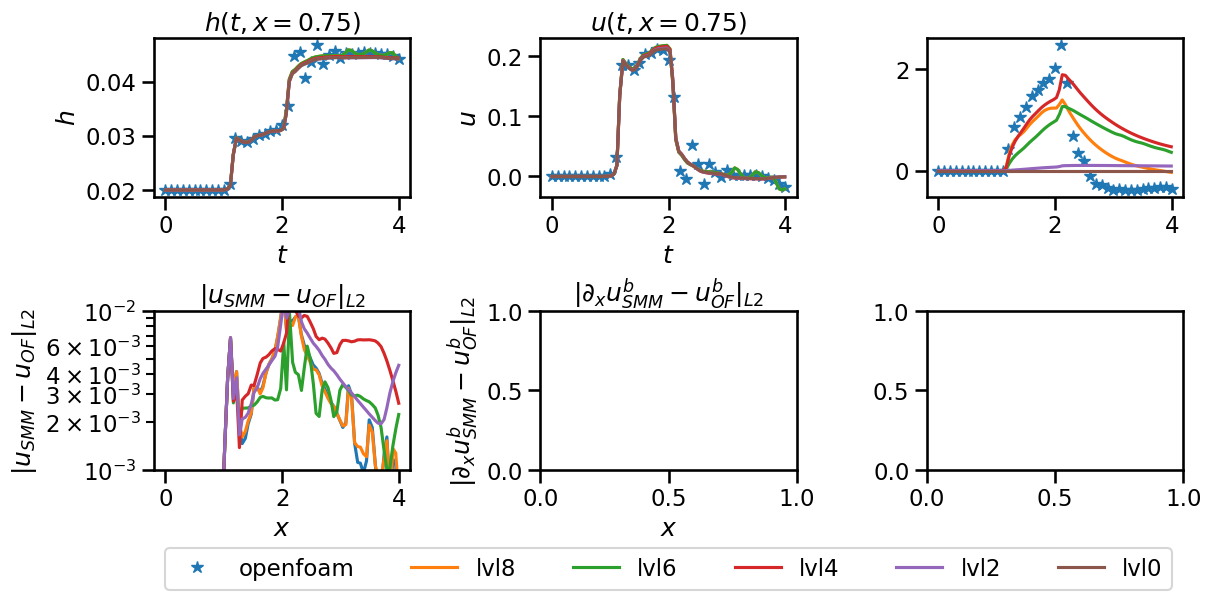

In [ ]:

fig = plt.figure(constrained_layout=True, figsize=(12, 6))
ax = fig.subplot_mosaic(
    [[0, 1, 4], [2, 3, 5], ["legend", "legend", "legend" ]],
    # per_subplot_kw={
    #     0: {"box_aspect": 0.6},
    #     1: {"box_aspect": 0.6},
    #     2: {"box_aspect": 1.0},
        # 3: {"box_aspect": 0.6},
    # },
    height_ratios=[1.3, 1.3, 0.3],
)

ax[0].set_title('$h(t, x=0.75)$')
ax[0].set_xlabel('$t$')
ax[0].set_ylabel('$h$')
ax[1].set_title('$u(t, x=0.75)$')
ax[1].set_xlabel('$t$')
ax[1].set_ylabel('$u$')
ax[2].set_title('$ |u_{SMM}-u_{OF}|_{L2}$')
ax[2].set_xlabel('$x$')
ax[2].set_ylabel('$|u_{SMM}-u_{OF}|_{L2}$')
ax[3].set_title('$|\partial_x u^b_{SMM}-u^b_{OF}|_{L2}$')
ax[3].set_xlabel('$x$')
ax[3].set_ylabel('$|\partial_x u^b_{SMM}-u^b_{OF}|_{L2}$')

# makers = ['*', '', '', '', '', '', '', '']
# linestyles = ['b', '', '', '', '', '', '', '']
for i, (k, v) in enumerate(dataset.items()):
    timeline = v['timeline']
    h = v['Q'][0]
    a = v['Q'][1:]
    shear = v['shear']
    print(shear.shape)
    if i == 0:
        ax[0].plot(timeline, h, '*', linestyle='', label='openfoam')
        ax[1].plot(timeline, a[0], '*', linestyle='', label='openfoam')
        ax[4].plot(timeline, shear, '*', linestyle='', label='openfoam')
    else:
        error = v['error']
        ax[0].plot(timeline, h, label=k)
        ax[1].plot(timeline, a[0], label=k)
        ax[4].plot(timeline, shear, label=k)
        ax[2].semilogy(timeline, error, label=k)


ax[2].set_ylim(10**(-3), 0.01)
handles, labels = ax[4].get_legend_handles_labels()
ax['legend'].legend(handles, labels, ncol=6, mode="expand", loc='lower left')
ax["legend"].axis("off")

# for i in range(3): 
#     ax[i].ticklabel_format(style='sci', scilimits=(0, 10))

# fig.savefig('TC1.png')


# Compare the water height of OpenFOAM and SMM at a meauring location

In [ ]:
pos = 0.5
# h_openfoam = experiments[str(pos)]["h"]
# timeline_openfoam = experiments[str(pos)]["timeline"]
h_openfoam, moments_openfoam, moments_w_openfoam, timeline_openfoam, u_openfoam, w_openfoam = project_openfoam_to_smm(directory, pos=[pos, 0, 0], stride=10, output_uw = True)
mom_u_openfoam = moments_openfoam[:, 0]
mom_a_openfoam = moments_openfoam[:, 1]
mom_a2_openfoam = moments_openfoam[:, 2]


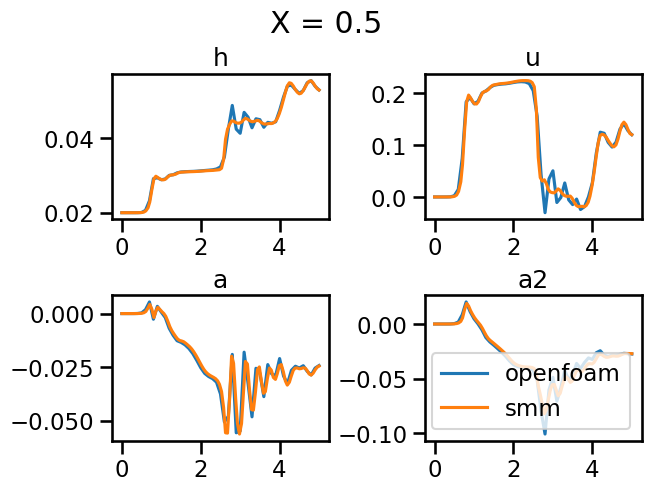

In [ ]:

x_smm, Q_smm, Qaux_smm, timeline_smm = io.load_timeline_of_fields_from_hdf5(os.path.join(settings.output_dir, "ShallowMoments.h5" ))
i_pos = ((x_smm-pos)**2).argmin()
h_smm = Q_smm[:, 0, i_pos]
u_smm = Q_smm[:, 1, i_pos]/h_smm
try:
    a_smm = Q_smm[:, 2, i_pos]/h_smm
except:
    a_smm = np.zeros_like(h_smm)
try:
    a2_smm = Q_smm[:, 3, i_pos]/h_smm
except:
    a2_smm = np.zeros_like(h_smm)

fig, ax = plt.subplots(2, 2, constrained_layout=True)
ax[0, 0].plot(timeline_openfoam, h_openfoam, label='openfoam')
ax[0, 0].plot(timeline_smm, h_smm, label='smm')
ax[0, 0].set_title('h')
ax[0, 1].plot(timeline_openfoam, mom_u_openfoam, label='openfoam')
ax[0, 1].plot(timeline_smm, u_smm, label='smm')
ax[0, 1].set_title('u')
ax[1, 0].plot(timeline_openfoam, mom_a_openfoam, label='openfoam')
ax[1, 0].plot(timeline_smm, a_smm, label='smm')
ax[1, 0].set_title('a')
ax[1, 1].plot(timeline_openfoam, mom_a2_openfoam, label='openfoam')
ax[1, 1].plot(timeline_smm, a2_smm, label='smm')
ax[1, 1].set_title('a2')
plt.suptitle(f"X = {pos}")
plt.legend()
fig.savefig("images/comp05.png")

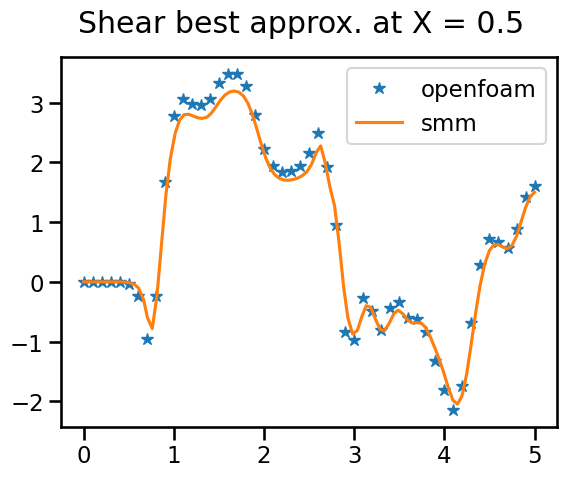

In [ ]:
shear_openfoam = shear_at_bottom_moments(moments_openfoam[:, :level+1])
moments_smm = Q_smm[:, 1:, i_pos]/np.repeat(h_smm, Q_smm.shape[1]-1).reshape((Q_smm.shape[0], Q_smm.shape[1]-1))
shear_smm = shear_at_bottom_moments(moments_smm)
fig, ax = plt.subplots()
ax.plot(timeline_openfoam, shear_openfoam, '*', label='openfoam')
ax.plot(timeline_smm, shear_smm, label='smm')
plt.suptitle(f"Shear best approx. at X = {pos}")
plt.legend()
fig.savefig("images/shear_ba_05.png")

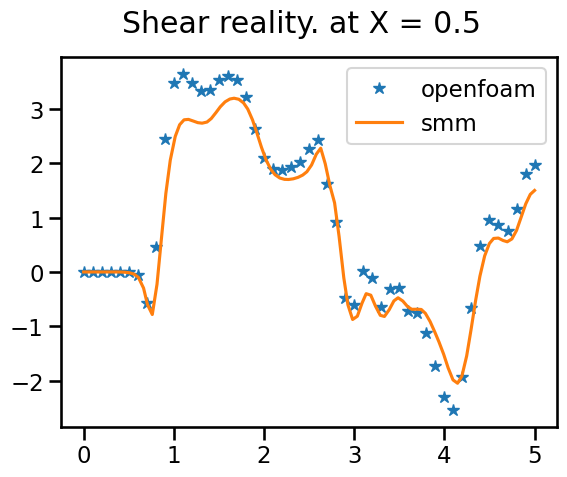

In [ ]:
shear_openfoam = shear_at_bottom_moments(moments_openfoam[:, :10])
moments_smm = Q_smm[:, 1:, i_pos]/np.repeat(h_smm, Q_smm.shape[1]-1).reshape((Q_smm.shape[0], Q_smm.shape[1]-1))
shear_smm = shear_at_bottom_moments(moments_smm)
fig, ax = plt.subplots()
ax.plot(timeline_openfoam, shear_openfoam, '*', label='openfoam')
ax.plot(timeline_smm, shear_smm, label='smm')
plt.suptitle(f"Shear reality. at X = {pos}")
plt.legend()
fig.savefig("images/shear_real_05.png")

In [ ]:
pos = 0.75
# h_openfoam = experiments[str(pos)]["h"]
# timeline_openfoam = experiments[str(pos)]["timeline"]
h_openfoam, moments_openfoam, moments_w_openfoam, timeline_openfoam, u_openfoam, w_openfoam = project_openfoam_to_smm(directory, pos=[pos, 0, 0], stride=10, output_uw = True)
mom_u_openfoam = moments_openfoam[:, 0]
mom_a_openfoam = moments_openfoam[:, 1]
mom_a2_openfoam = moments_openfoam[:, 2]


ValueError: x and y must have same first dimension, but have shapes (89,) and (79,)

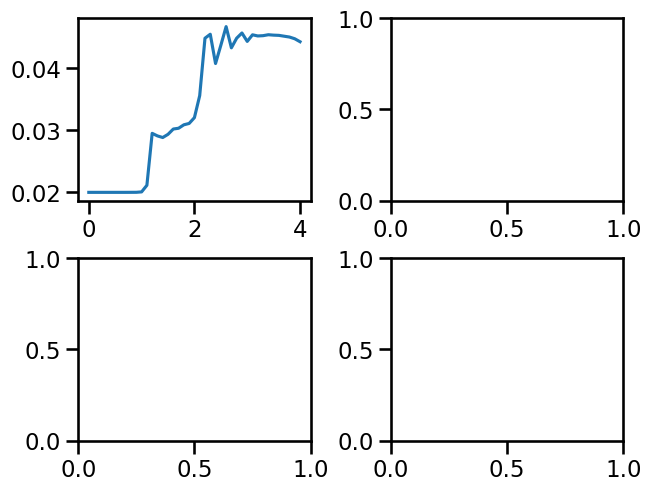

In [ ]:
# x_smm, Q_smm, Qaux_smm, timeline_smm = io.load_timeline_of_fields_from_hdf5(os.path.join(settings.output_dir, "ShallowMoments.h5" ))
x_smm, Q_smm, Qaux_smm, timeline_smm = io.load_timeline_of_fields_from_hdf5(os.path.join('outputs/save_ijshs', "lvl8_chezy10.h5" ))
i_pos = ((x_smm-pos)**2).argmin()
h_smm = Q_smm[:, 0, i_pos]
u_smm = Q_smm[:, 1, i_pos]/h_smm
try:
    a_smm = Q_smm[:, 2, i_pos]/h_smm
except:
    a_smm = np.zeros_like(h_smm)
try:
    a2_smm = Q_smm[:, 3, i_pos]/h_smm
except:
    a2_smm = np.zeros_like(h_smm)


fig, ax = plt.subplots(2, 2, constrained_layout=True)
ax[0, 0].plot(timeline_openfoam[:-10], h_openfoam[:-10], label='openfoam')
ax[0, 0].plot(timeline_smm[:-10], h_smm[:-20], label='smm')
ax[0, 0].set_title('h')
ax[0, 1].plot(timeline_openfoam[:-10], mom_u_openfoam[:-10],'*', label='openfoam')
ax[0, 1].plot(timeline_smm[:-20], u_smm[:-20], label='smm')
ax[0, 1].set_title('u')
ax[1, 0].plot(timeline_openfoam[:-10], mom_a_openfoam[:-10], '*', label='openfoam')
ax[1, 0].plot(timeline_smm, a_smm, label='smm')
ax[1, 0].set_title('a')
ax[1, 1].plot(timeline_openfoam, mom_a2_openfoam,'*', label='openfoam')
ax[1, 1].plot(timeline_smm, a2_smm, label='smm')
ax[1, 1].set_title('a2')
plt.suptitle(f"X = {pos}")
plt.legend()
fig.savefig("images/comp12.png")

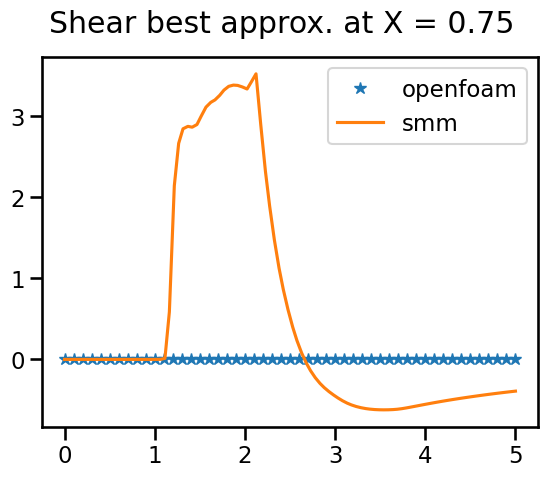

In [ ]:

shear_openfoam = shear_at_bottom_moments(moments_openfoam[:, :level+1])
moments_smm = Q_smm[:, 1:, i_pos]/np.repeat(h_smm, Q_smm.shape[1]-1).reshape((Q_smm.shape[0], Q_smm.shape[1]-1))
shear_smm = shear_at_bottom_moments(moments_smm)
fig, ax = plt.subplots()
ax.plot(timeline_openfoam, shear_openfoam, '*', label='openfoam')
ax.plot(timeline_smm, shear_smm, label='smm')
plt.suptitle(f"Shear best approx. at X = {pos}")
plt.legend()
fig.savefig("images/shear_ba_12.png")


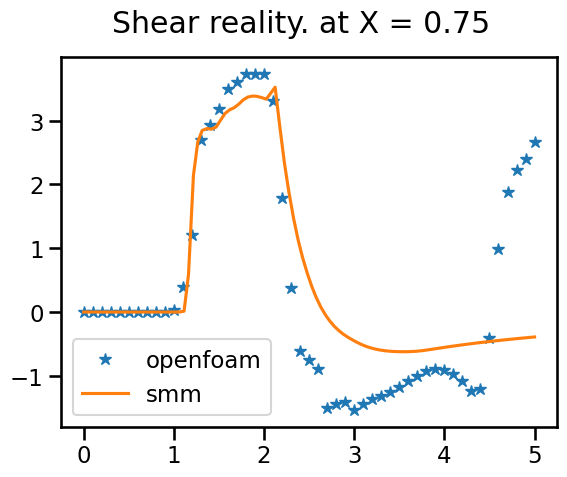

In [ ]:

shear_openfoam = shear_at_bottom_moments(moments_openfoam[:, :])
moments_smm = Q_smm[:, 1:, i_pos]/np.repeat(h_smm, Q_smm.shape[1]-1).reshape((Q_smm.shape[0], Q_smm.shape[1]-1))
shear_smm = shear_at_bottom_moments(moments_smm)
fig, ax = plt.subplots()
ax.plot(timeline_openfoam, shear_openfoam, '*', label='openfoam')
ax.plot(timeline_smm, shear_smm, label='smm')
plt.suptitle(f"Shear reality. at X = {pos}")
plt.legend()
fig.savefig("images/shear_real_12.png")

In [ ]:
pos = 0.95
# h_openfoam = experiments[str(pos)]["h"]
# timeline_openfoam = experiments[str(pos)]["timeline"]
h_openfoam, moments_openfoam, moments_w_openfoam, timeline_openfoam, u_openfoam, w_openfoam = project_openfoam_to_smm(directory, pos=[pos, 0, 0], stride=10, output_uw = True)
mom_u_openfoam = moments_openfoam[:, 0]
mom_a_openfoam = moments_openfoam[:, 1]
mom_a2_openfoam = moments_openfoam[:, 2]



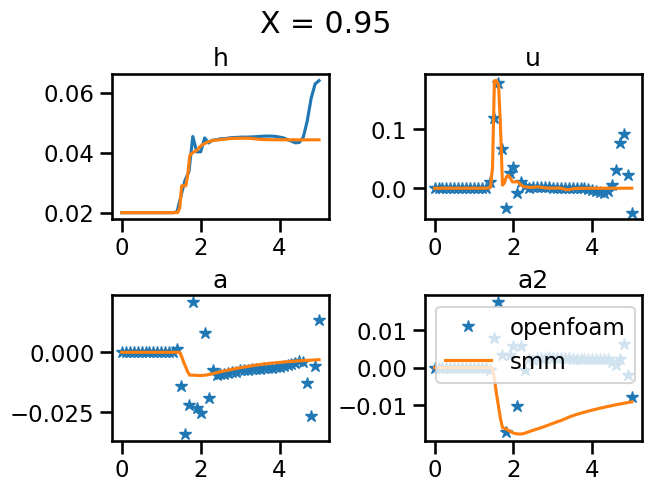

In [ ]:
x_smm, Q_smm, Qaux_smm, timeline_smm = io.load_timeline_of_fields_from_hdf5(os.path.join(settings.output_dir, "ShallowMoments.h5" ))
i_pos = ((x_smm-pos)**2).argmin()
h_smm = Q_smm[:, 0, i_pos]
u_smm = Q_smm[:, 1, i_pos]/h_smm
try:
    a_smm = Q_smm[:, 2, i_pos]/h_smm
except:
    a_smm = np.zeros_like(h_smm)
try:
    a2_smm = Q_smm[:, 3, i_pos]/h_smm
except:
    a2_smm = np.zeros_like(h_smm)

fig, ax = plt.subplots(2, 2, constrained_layout=True)
ax[0, 0].plot(timeline_openfoam, h_openfoam, label='openfoam')
ax[0, 0].plot(timeline_smm, h_smm, label='smm')
ax[0, 0].set_title('h')
ax[0, 1].plot(timeline_openfoam, mom_u_openfoam, '*', label='openfoam')
ax[0, 1].plot(timeline_smm, u_smm, label='smm')
ax[0, 1].set_title('u')
ax[1, 0].plot(timeline_openfoam, mom_a_openfoam, '*',label='openfoam')
ax[1, 0].plot(timeline_smm, a_smm, label='smm')
ax[1, 0].set_title('a')
ax[1, 1].plot(timeline_openfoam, mom_a2_openfoam, '*',label='openfoam')
ax[1, 1].plot(timeline_smm, a2_smm, label='smm')
ax[1, 1].set_title('a2')
plt.suptitle(f"X = {pos}")
plt.legend()
fig.savefig("images/comp25.png")

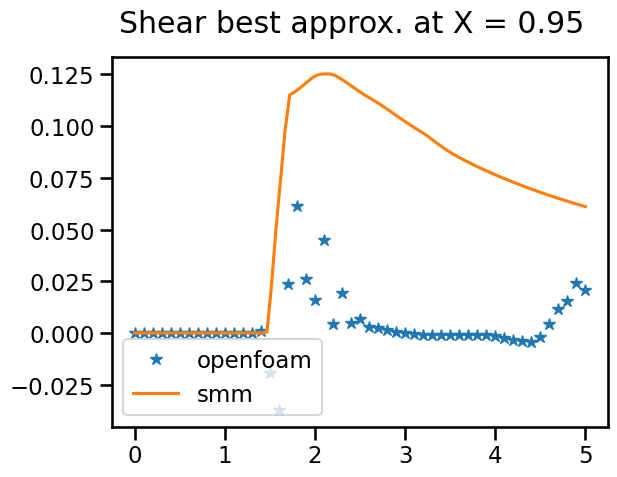

In [ ]:


shear_openfoam = shear_at_bottom_moments(moments_openfoam[:, :level+1])
moments_smm = Q_smm[:, 1:, i_pos]/np.repeat(h_smm, Q_smm.shape[1]-1).reshape((Q_smm.shape[0], Q_smm.shape[1]-1))
shear_smm = shear_at_bottom_moments(moments_smm)
fig, ax = plt.subplots()
ax.plot(timeline_openfoam, shear_openfoam, '*',label='openfoam')
ax.plot(timeline_smm, shear_smm, label='smm')
plt.suptitle(f"Shear best approx. at X = {pos}")
plt.legend()
fig.savefig("images/shear_ba_25.png")


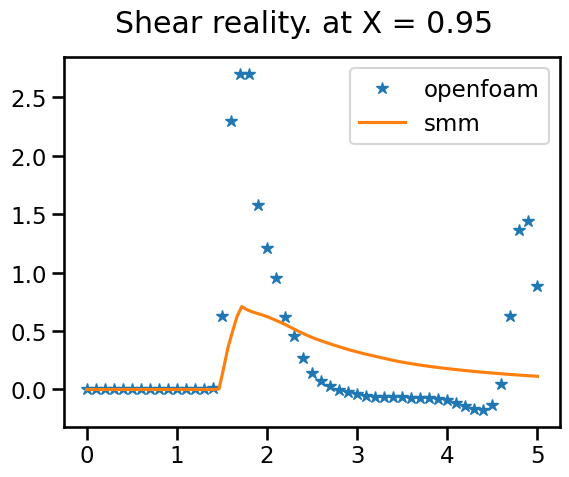

In [ ]:

shear_openfoam = shear_at_bottom_moments(moments_openfoam[:, :10])
moments_smm = Q_smm[:, 1:, i_pos]/np.repeat(h_smm, Q_smm.shape[1]-1).reshape((Q_smm.shape[0], Q_smm.shape[1]-1))
shear_smm = shear_at_bottom_moments(moments_smm)
fig, ax = plt.subplots()
ax.plot(timeline_openfoam, shear_openfoam, '*',label='openfoam')
ax.plot(timeline_smm, shear_smm, label='smm')
plt.suptitle(f"Shear reality. at X = {pos}")
plt.legend()
fig.savefig("images/shear_real_25.png")